# The Challenge

"The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc)."

# Define the problem

Use machine learning to create a model that predicts what sorts of people were more likely to survive.

# Libraries and files

In [1162]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import Perceptron
from sklearn.naive_bayes import GaussianNB

In [1163]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# Structures of data

In [1164]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [1165]:
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


## Data dictionary    
    #Variable  #Definition                   #Key
    ____________________________________________________________________________________
    Survival   Survival                     [0] = No, [1] = Yes
    
    Pclass     Ticket class                 [1] = 1st(upper deck), 
                                            [2] = 2nd(middle deck), 
                                            [3] = 3rd(lower deck)
    
    Sex        Sex                          [male]/[female]
    
    Age        Age in years                 Age is fractional if less than 1. 
                                            If the age is estimated, 
                                            is it in the form of xx.5                       
    
    SibSp      of siblings /                Sibling = brother, sister,
               spouses aboard the Titanic   stepbrother, stepsister; 
                                            Spouse = husband, wife 
                                            (mistresses and fiancés were ignored). 
                                                          
    Parch      of parents /                 Parent = mother, father;
               children aboard the Titanic  Child = daughter, son, stepdaughter, stepson;
                                            Some children travelled only with a nanny,
                                            therefore parch= [0] for them. 
                                                          
    Ticket     Ticket number                                  
    
    Fare       Passenger fare
    
    Cabin      Cabin number                                   
    
    Embarked   Port of Embarkation          [S] = Southampton, 
                                            [C] = Cherbourg, 
                                            [Q] = Queenstown, 
                                            in order of visited harbour
    ____________________________________________________________________________________

* Categorical:
    * Nominal
        * Sex
        * Cabin
        * Embarked
        * Name
        * Ticket
        * Survived
    * Ordinal
        * Pclass    
* Numerical:
    * Discrete
        * PassengerId
        * SibSp
        * Parch
    * Continous
        * Age
        * Fare

## Insights 1

* 'Survived'. This is the target column/variable.
* 'PassengerId', 'Ticket' seems to be not related to 'Survived'.
* 'Pclass', 'Sex', 'Age' and 'Embarked' are likely to have the most significant 'Survived' impact.
* 'Name' could be used to make 'Title' column. It could sugests 'Age'.
* 'SibSp' and 'Parch' could be used to make 'Family' column.
* 'Cabin' have got more than 75% of missing values.
* 'Age', 'Fare' are continous and have got less than 25% of missing data.
    * 'Age' is most importand among variables with missing data.
    * 'Fare' might be related to Pclass

## Correlation heatmap

In [1041]:
heatmap_features = ["Survived", "Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]
# "Sex", "Embarked" are nominal, so we need to use get_dummy
heatmap_df = pd.get_dummies(train_data[heatmap_features])

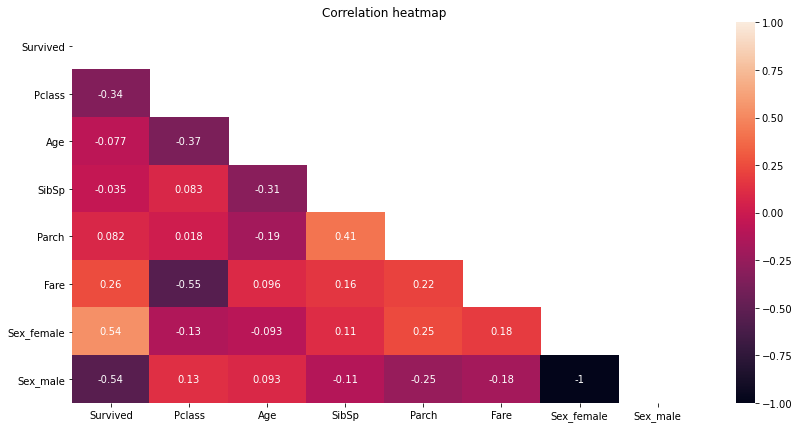

In [1042]:
# Correlation heatmap
plt.figure(figsize=(14, 7))
# Masking the upper triangle part of the matrix
heat_mask = np.triu(np.ones_like(heatmap_df.corr(), dtype=np.bool))
sns.heatmap(heatmap_df.corr(), mask=heat_mask, vmin=-1, vmax=1, annot=True)
plt.title("Correlation heatmap");

## Percent survivabilty

In [1043]:
# df with percent of Survived by Pclass, Sex, SibSp, Parch
class_df = round(train_data[['Survived', 'Pclass']].groupby(['Pclass']).mean()*100,2)
emb_df = round(train_data[['Survived', 'Embarked']].groupby(['Embarked']).mean()*100,2)
sex_df = round(train_data[['Survived', 'Sex']].groupby(['Sex']).mean()*100,2)
sib_df = round(train_data[['Survived', 'SibSp']].groupby(['SibSp']).mean()*100,2)
par_df = round(train_data[['Survived', 'Parch']].groupby(['Parch']).mean()*100,2)

In [1044]:
class_df

,Survived
Pclass,
1,62.96
2,47.28
3,24.24


Text(0.5, 1.0, 'Survived among Pclass')

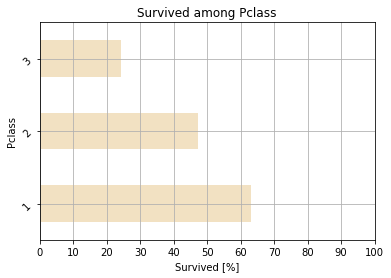

In [1045]:
# Survived among 'Pclass'
class_df.plot(kind='barh', grid=True, color='#F2E1C2',
              rot=45, legend=False, xticks=range(0, 105, 10))
plt.xlabel("Survived [%]")
plt.title("Survived among Pclass")

In [1046]:
emb_df

,Survived
Embarked,
C,55.36
Q,38.96
S,33.70


Text(0.5, 1.0, 'Survived among Embarked')

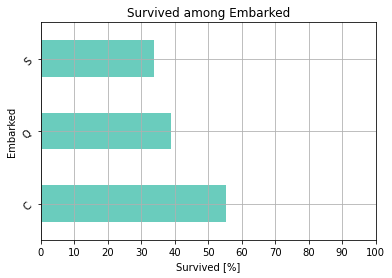

In [1047]:
# Survived among 'Embarked'
emb_df.plot(kind='barh', grid=True, color='#6ACCBD',
              rot=45, legend=False, xticks=range(0, 105, 10))
plt.xlabel("Survived [%]")
plt.title("Survived among Embarked")

In [1048]:
sex_df

,Survived
Sex,
female,74.20
male,18.89


Text(0.5, 1.0, 'Survived among Sex')

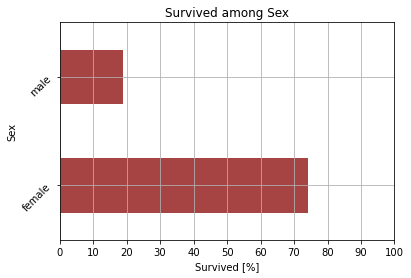

In [1049]:
# Survived among 'Sex'
sex_df.plot(kind='barh', grid=True, color='#A64444',
              rot=45, legend=False, xticks=range(0, 105, 10))
plt.xlabel("Survived [%]")
plt.title("Survived among Sex")

In [1050]:
# summary percent of Survived and mean Age of survivors in Embarked, Pclass, Sex
sum_survived = round(train_data[['Embarked', 'Pclass', 'Sex', 'Survived']]
                       .groupby(['Embarked', 'Pclass', 'Sex']).mean()*100, 2)

sum_age = round(train_data[['Embarked', 'Pclass', 'Sex', 'Age']]
                  .groupby(['Embarked', 'Pclass', 'Sex']).mean())

sum_count = train_data[['Embarked', 'Pclass', 'Sex', 'Survived']].groupby(['Embarked', 'Pclass', 'Sex']).count()

In [1051]:
sum_df = pd.concat([sum_survived, sum_age, sum_count], axis=1)
sum_df.columns = ['Survived %', 'Mean Age', 'Quantity']
sum_df

Survived %  Mean Age  Quantity
Embarked Pclass Sex                                   
C        1      female       97.67      36.0        43
                male         40.48      40.0        42
         2      female      100.00      19.0         7
                male         20.00      26.0        10
         3      female       65.22      14.0        23
                male         23.26      25.0        43
Q        1      female      100.00      33.0         1
                male          0.00      44.0         1
         2      female      100.00      30.0         2
                male          0.00      57.0         1
         3      female       72.73      23.0        33
                male          7.69      28.0        39
S        1      female       95.83      33.0        48
                male         35.44      42.0        79
         2      female       91.04      30.0        67
                male         15.46      31.0        97
         3      female       37.50      23.0        88
                male         12.83      27.0       265

In [1052]:
sum_df = sum_df.reset_index()

In [1053]:
sum_df['Emb_Class_Sex'] = sum_df['Embarked'].astype(str)+'_'+sum_df['Pclass'].astype(str)+'_'+sum_df['Sex']

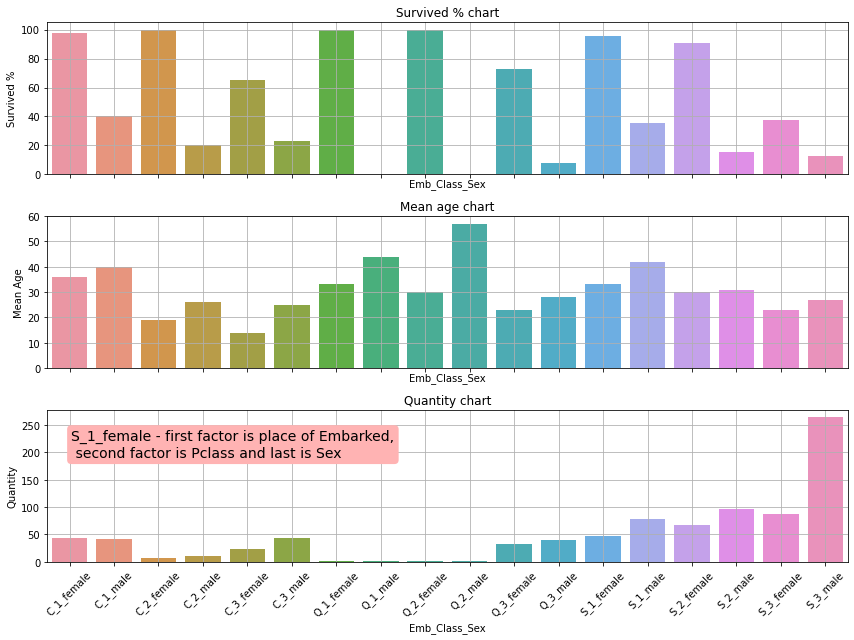

In [1054]:
fig, axes = plt.subplots(3, 1, figsize=(12, 9), sharex=True)

# Survived subplot
sns.barplot(ax=axes[0], data=sum_df, x='Emb_Class_Sex', y='Survived %')
axes[0].set_title("Survived % chart")
axes[0].grid(True)

# Mean Age subplot
sns.barplot(ax=axes[1], data=sum_df, x='Emb_Class_Sex', y='Mean Age')
axes[1].set_title("Mean age chart")
axes[1].set_yticks(range(0,70,10))
axes[1].grid(True)

# Quantity subplot
sns.barplot(ax=axes[2], data=sum_df, x='Emb_Class_Sex', y='Quantity')
axes[2].tick_params(axis='x', rotation=45)
axes[2].set_title("Quantity chart")
axes[2].set_yticks(range(0,300,50))
axes[2].grid(True)

# Annotation for x label explanation
plt.annotate("S_1_female - first factor is place of Embarked,\n second factor is Pclass and last is Sex", 
            xy=(0.03,0.69), xycoords='axes fraction', size=14,
            bbox=dict(boxstyle="round", fc=(1.0, 0.7, 0.7), ec="none"))

plt.tight_layout();

In [1055]:
sib_df

,Survived
SibSp,
0,34.54
1,53.59
2,46.43
3,25.00
4,16.67
5,0.00
8,0.00


Text(0.5, 1.0, 'Survived among SibSp')

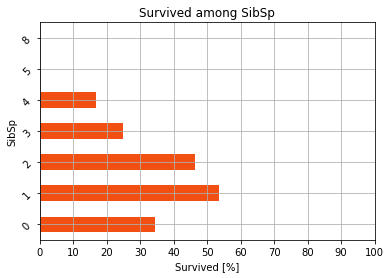

In [1056]:
# Survived among 'SibSp'
sib_df.plot(kind='barh', grid=True, color='#F24F13',
              rot=45, legend=False, xticks=range(0, 105, 10))
plt.xlabel("Survived [%]")
plt.title("Survived among SibSp")

In [1057]:
par_df

,Survived
Parch,
0,34.37
1,55.08
2,50.00
3,60.00
4,0.00
5,20.00
6,0.00


Text(0.5, 1.0, 'Survived among Parch')

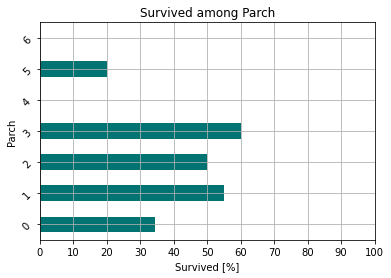

In [1058]:
# Survived among 'Parch'
par_df.plot(kind='barh', grid=True, color='#027373',
              rot=45, legend=False, xticks=range(0, 105, 10))
plt.xlabel("Survived [%]")
plt.title("Survived among Parch")

In [1059]:
# df with Age bands
train_data['AgeBand'] = pd.qcut(train_data['Age'], 5)
age_df = round(train_data[['AgeBand', 'Survived']].groupby(['AgeBand']).mean()*100, 2)

In [1060]:
age_df

,Survived
AgeBand,
"(0.419, 19.0]",48.17
"(19.0, 25.0]",32.85
"(25.0, 31.8]",39.37
"(31.8, 41.0]",43.75
"(41.0, 80.0]",37.32


Text(0.5, 1.0, 'Survivability among Age bands')

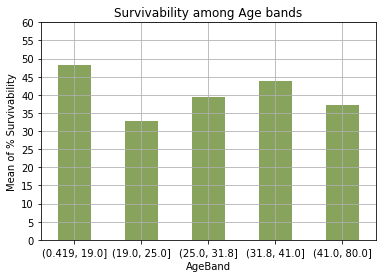

In [1061]:
# Survived among 'Age' bands
age_df.plot(kind='bar', color='#88A35B', rot=0,
             grid=True, legend=False, yticks=range(0, 65, 5))

plt.ylabel("Mean of % Survivability")
plt.title("Survivability among Age bands")

In [1062]:
# df with Fare bands
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
fare_df = round(train_data[['FareBand', 'Survived']].groupby(['FareBand']).mean()*100, 2)

In [1063]:
fare_df

,Survived
FareBand,
"(-0.001, 7.91]",19.73
"(7.91, 14.454]",30.36
"(14.454, 31.0]",45.50
"(31.0, 512.329]",58.11


Text(0.5, 1.0, 'Survivability among Fare bands')

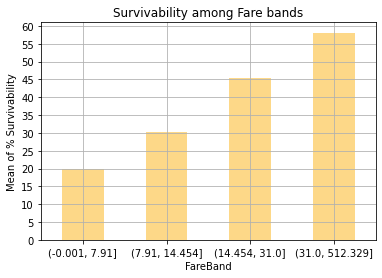

In [1064]:
# Survived among 'Fare' bands
fare_df.plot(kind='bar', color='#FDD888', rot=0,
             grid=True, legend=False, yticks=range(0, 65, 5))

plt.ylabel("Mean of % Survivability")
plt.title("Survivability among Fare bands")

## Insights 2

* If you were in Titanic you would be:
    * in 1 class instead of 2, 3
        * survivability 62%
    * from C instead of Q, S
        * survivability 55%
    * female instead of male
        * survivability 72%
    * 1-2 Siblings/Spouses
        * survivability 46-54%
    * 1-3 Parent/Childen
        * survivability 50-60%
    * Relatively younger people had more chances to survive.
        * under 19 years old - survivability above 48%
        * above 19 years old - survivability under 33-44%
    * Relatively people who paid more had got more chances to survive.
        * those who paid less than 14 £ - survivability 20-30%
        * those who paid more than 14 £ - survivability 45-57%

* Decisions:
    * Title extracting and grouping.
    * Handling missing data.
    * SibSp and Parch should be reducted to keep simplicity.
    * Continous variable (Age, Fare) grouping into bands.
    * Converting categorical feature (Title, Embarked, Sex) to numeric.  

# Data processing

## Missing data - imputation

### Age

In [1065]:
# percent of data missing
train_missing = round(train_data.isnull().sum().sort_values\
                      (ascending=False)/len(train_data)*100,2)
test_missing = round(test_data.isnull().sum().sort_values\
                     (ascending=False)/len(test_data)*100,2)

In [1066]:
train_missing

Cabin          77.10
Age            19.87
AgeBand        19.87
Embarked        0.22
PassengerId     0.00
Survived        0.00
Pclass          0.00
Name            0.00
Sex             0.00
SibSp           0.00
Parch           0.00
Ticket          0.00
Fare            0.00
FareBand        0.00
dtype: float64

In [1067]:
test_missing

Cabin          78.23
Age            20.57
Fare            0.24
PassengerId     0.00
Pclass          0.00
Name            0.00
Sex             0.00
SibSp           0.00
Parch           0.00
Ticket          0.00
Embarked        0.00
dtype: float64

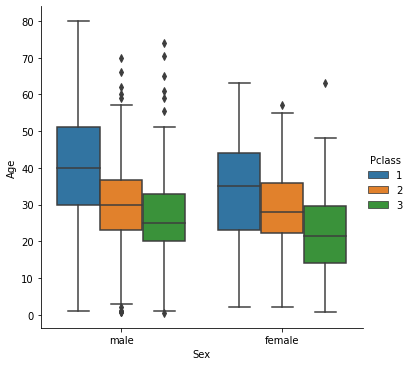

In [1068]:
sns.catplot(kind='box', x='Sex', y='Age', hue='Pclass', data=train_data)

In [1069]:
# Grouping age by Sex and Pclass to retrive median values
for df, name in zip([train_data, test_data], ['train data', 'test data']):
    age_by_pclass_sex = df.groupby(['Sex', 'Pclass']).median()['Age']
    print(f"Imputing following values for {name}\n {age_by_pclass_sex}\n\n")

    # Filling the missing values in Age with the medians
    df['Age'] = df.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Imputing following values for train data
 Sex     Pclass
female  1         35.0
        2         28.0
        3         21.5
male    1         40.0
        2         30.0
        3         25.0
Name: Age, dtype: float64


Imputing following values for test data
 Sex     Pclass
female  1         41.0
        2         24.0
        3         22.0
male    1         42.0
        2         28.0
        3         24.0
Name: Age, dtype: float64




### Fare and Embarked

In [1070]:
# imputing Fare median
test_data['Fare'].fillna(value=train_data['Fare'].median(), inplace=True)
# imputing Embarked mode
train_data['Embarked'].fillna(value=train_data['Embarked'].mode()[0], inplace=True)

## Outliners - winsorization

### Age & Fare

<AxesSubplot:>

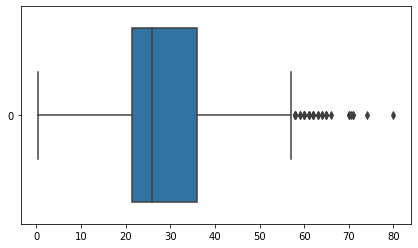

In [1071]:
# Age
plt.figure(figsize=(7,4))
sns.boxplot(data=train_data['Age'], orient='h')

In [1072]:
train_data['Age'].describe()

count    891.000000
mean      29.112424
std       13.304424
min        0.420000
25%       21.500000
50%       26.000000
75%       36.000000
max       80.000000
Name: Age, dtype: float64

In [1073]:
# Interquartile Range means Q3 - Q1 
print("Q3 + 1.5 * (IQR):", 36+1.5*(36-21.5))

Q3 + 1.5 * (IQR): 57.75


In [1074]:
# Replacing outliners with the nearest value, not trimming
train_data.loc[train_data['Age'] > 57, 'Age'] = 57
train_data['Age'] = train_data['Age'].astype(int)

# train_data.drop(train_data[train_data.Age > 75].index, inplace=True)

<AxesSubplot:>

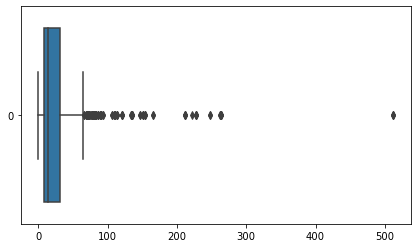

In [1075]:
# Fare
plt.figure(figsize=(7,4))
sns.boxplot(data=train_data['Fare'], orient='h')

In [1076]:
train_data['Fare'].describe()

count    891.000000
mean      32.204208
std       49.693429
min        0.000000
25%        7.910400
50%       14.454200
75%       31.000000
max      512.329200
Name: Fare, dtype: float64

In [1077]:
# Interquartile Range means Q3 - Q1 
print("Q3 + 1.5 * (IQR):", 31+1.5*(31-7.9))

Q3 + 1.5 * (IQR): 65.65


In [1078]:
# Replacing outliners with the nearest value, not trimming
train_data.loc[train_data['Fare'] > 65, 'Fare'] = 65
train_data['Fare'] = train_data['Fare'].astype(int)

### SibSp & Parch

<AxesSubplot:>

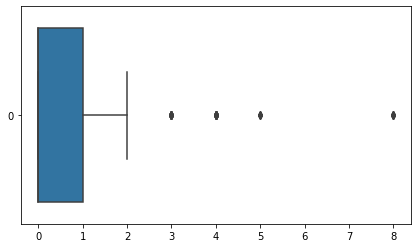

In [1079]:
# SibSp
plt.figure(figsize=(7,4))
sns.boxplot(data=train_data['SibSp'], orient='h')

In [1080]:
# Replacing outliners with the nearest value, not trimming
train_data.loc[train_data['SibSp'] > 5, 'SibSp'] = 5
train_data['SibSp'] = train_data['SibSp'].astype(int)

<AxesSubplot:>

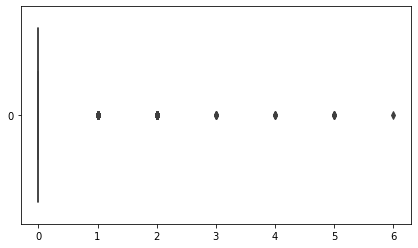

In [1081]:
# Parch
plt.figure(figsize=(7,4))
sns.boxplot(data=train_data['Parch'], orient='h')

In [1082]:
# Replacing outliners with the nearest value, not trimming
train_data.loc[train_data['Parch'] > 5, 'Parch'] = 5
train_data['Parch'] = train_data['Parch'].astype(int)

## Cabin

<AxesSubplot:xlabel='Cabin', ylabel='Survived'>

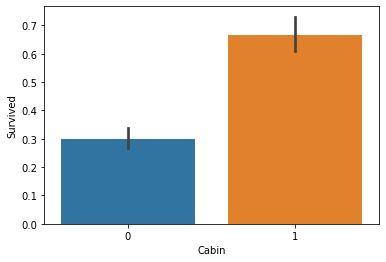

In [1083]:
# Cabin mapping and converting
for df in [train_data, test_data]:
    df.loc[df['Cabin'].notnull(), 'Cabin'] = 1
    df.loc[df['Cabin'].isnull(), 'Cabin'] = 0
    df['Cabin'] = df['Cabin'].astype(int)

sns.barplot(x='Cabin', y='Survived', data=train_data)

## Pclass

<AxesSubplot:xlabel='Pclass', ylabel='Survived'>

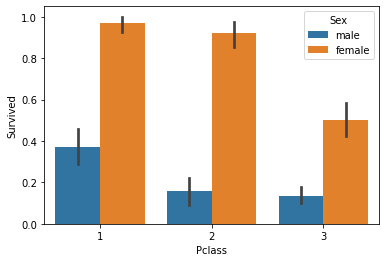

In [1084]:
sns.barplot(x='Pclass', y='Survived', hue='Sex', data=train_data)

In [1085]:
# Sex converting
for df in [train_data, test_data]:
    df['Pclass'] = df['Pclass'].astype('category')

## Sex=Female

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

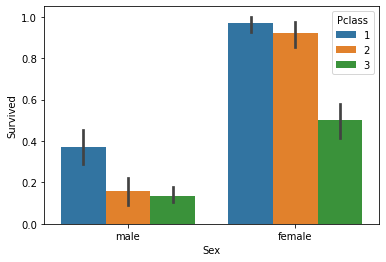

In [1086]:
sns.barplot(x='Sex', y='Survived', hue='Pclass', data=train_data)

In [1087]:
# sex converting
for df in [train_data, test_data]:
    df.rename(columns={'Sex': 'Female'}, inplace=True)
    df['Female'] = df['Female'].map({'female': 1, 'male': 0}).astype(int)

## Age & Fare

In [1088]:
# Age band
train_data['AgeBand'] = pd.qcut(train_data['Age'], 5)
round(train_data[['AgeBand', 'Survived']].groupby(['AgeBand']).mean()*100, 2)

,Survived
AgeBand,
"(-0.001, 20.0]",45.56
"(20.0, 25.0]",29.57
"(25.0, 30.0]",38.02
"(30.0, 40.0]",44.86
"(40.0, 57.0]",37.16


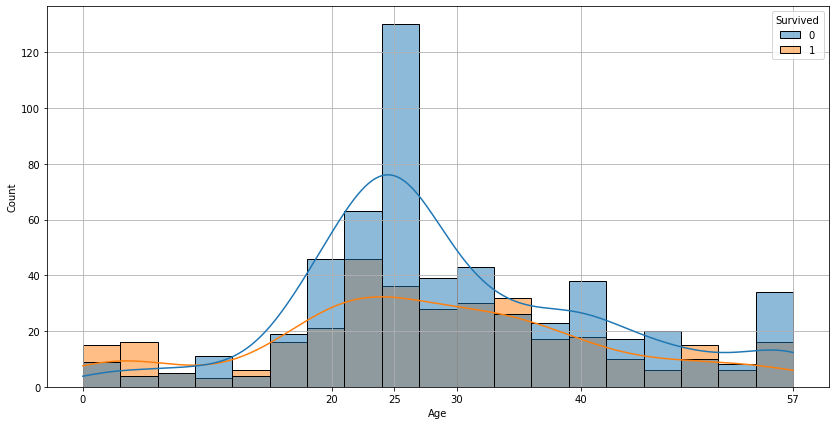

In [1089]:
plt.figure(figsize=(14,7))
sns.histplot(data=train_data, x='Age', hue='Survived', kde=True)
plt.xticks([0, 20, 25, 30, 40, 57])
plt.grid()

In [1090]:
# Age band mapping into 5
for df in [train_data, test_data]:    
    df.loc[df['Age'] <= 20, 'Age'] = 1
    df.loc[(df['Age'] > 20) & (df['Age'] <= 25), 'Age'] = 2
    df.loc[(df['Age'] > 25) & (df['Age'] <= 30), 'Age'] = 3
    df.loc[(df['Age'] > 30) & (df['Age'] <= 40), 'Age'] = 4
    df.loc[df['Age'] > 40, 'Age'] = 5
    df['Age'] = df['Age'].astype(int)
    
    age_map = {1: 'Under-20', 2: '20-25', 3: '25-30', 4: '30-40', 5: 'Above-40'}
    df['Age'] = df['Age'].map(age_map)

In [1091]:
# Fare band
train_data['FareBand'] = pd.qcut(train_data['Fare'], 4)
round(train_data[['FareBand', 'Survived']].groupby(['FareBand']).mean()*100, 2)

,Survived
FareBand,
"(-0.001, 7.0]",21.58
"(7.0, 14.0]",28.70
"(14.0, 31.0]",45.74
"(31.0, 65.0]",59.72


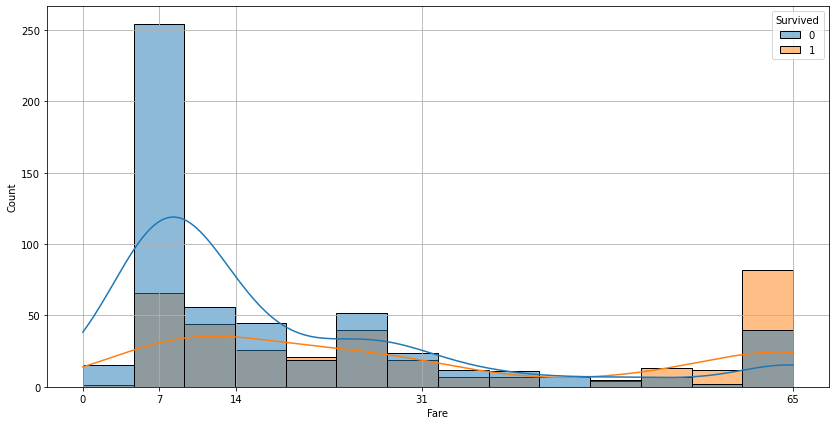

In [1092]:
plt.figure(figsize=(14,7))
sns.histplot(data=train_data, x='Fare', hue='Survived', kde=True)
plt.xticks([0, 7, 14, 31, 65])
plt.grid()

In [1093]:
# Fare band mapping into 4
for df in [train_data, test_data]:
    df.loc[ df['Fare'] <= 7, 'Fare'] = 1
    df.loc[(df['Fare'] > 7) & (df['Fare'] <= 14), 'Fare'] = 2
    df.loc[(df['Fare'] > 14) & (df['Fare'] <= 31), 'Fare'] = 3
    df.loc[ df['Fare'] > 31, 'Fare'] = 4
    df['Fare'] = df['Fare'].astype(int)
    
    fare_map = {1: 'Under-8', 2: '7-14', 3: '14-31', 4: 'Above-31'}
    df['Fare'] = df['Fare'].map(fare_map)

## Title 

In [1094]:
# extracting title from name
train_data['Title'], test_data['Title'] = [df.Name.str.extract \
        (' ([A-Za-z]+)\.', expand=False) for df in [train_data, test_data]]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 [Text(0, 0, 'Mr'),
  Text(1, 0, 'Mrs'),
  Text(2, 0, 'Miss'),
  Text(3, 0, 'Master'),
  Text(4, 0, 'Don'),
  Text(5, 0, 'Rev'),
  Text(6, 0, 'Dr'),
  Text(7, 0, 'Mme'),
  Text(8, 0, 'Ms'),
  Text(9, 0, 'Major'),
  Text(10, 0, 'Lady'),
  Text(11, 0, 'Sir'),
  Text(12, 0, 'Mlle'),
  Text(13, 0, 'Col'),
  Text(14, 0, 'Capt'),
  Text(15, 0, 'Countess'),
  Text(16, 0, 'Jonkheer')])

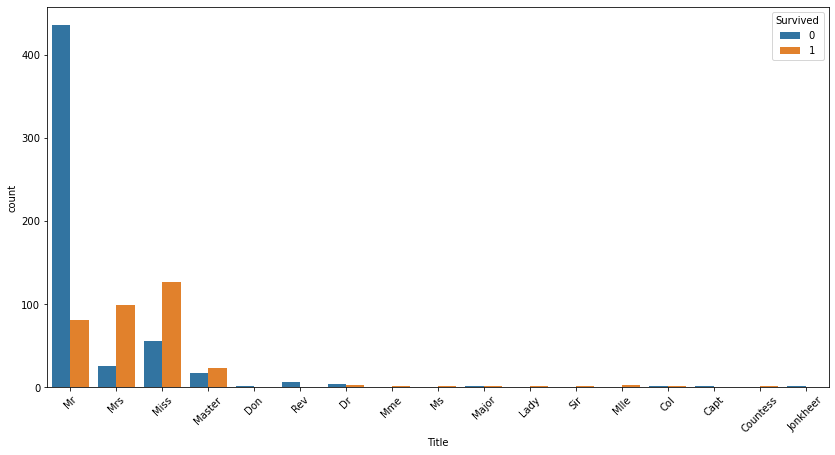

In [1095]:
plt.figure(figsize=(14,7))
sns.countplot(x='Title', hue='Survived', data=train_data)
plt.xticks(rotation=45)

In [1096]:
#  maping titles
title_dict = {    
              "Mr":"Mr",
              "Mrs":"Mrs",
              "Miss":"Miss",
              "Master":"Master",

              "Don":"Other",
              "Dona":"Other",
              "Rev":"Other",
              "Dr":"Other",
              "Mme":"Mrs",
              "Ms":"Mrs",
              "Major":"Other",
              "Lady":"Other",
              "Sir":"Other",
              "Mlle":"Miss",
              "Col":"Other",
              "Capt":"Other",
              "Countess":"Other",
              "Jonkheer":"Other"}    

# reducting number of titles
train_data['Title'], test_data['Title'] = [df.Title.map(title_dict) for df in [train_data, test_data]]

<AxesSubplot:xlabel='Title', ylabel='Survived'>

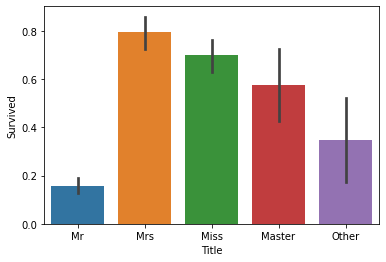

In [1097]:
sns.barplot(x='Title', y='Survived', data=train_data)

## Family size

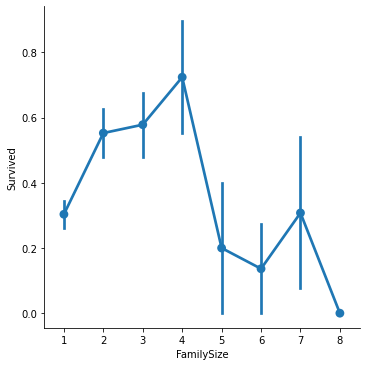

In [1098]:
# family size
for df in [train_data, test_data]:
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

sns.catplot(kind='point', x='FamilySize', y='Survived', data=train_data)

In [1099]:
family_dict = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 
               5: 'Large', 6: 'Large', 7: 'Large', 8: 'Large'}

for df in [train_data, test_data]:    
    df['FamilySize'] = df.FamilySize.map(family_dict)

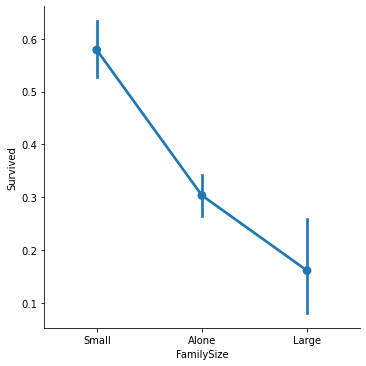

In [1100]:
sns.catplot(kind='point', x='FamilySize', y='Survived', data=train_data)

# Target, Features

In [1101]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Female,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBand,FareBand,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",0,20-25,1,0,A/5 21171,Under-8,0,S,"(20.0, 25.0]","(-0.001, 7.0]",Mr,Small
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,30-40,1,0,PC 17599,Above-31,1,C,"(30.0, 40.0]","(31.0, 65.0]",Mrs,Small
2,3,1,3,"Heikkinen, Miss. Laina",1,25-30,0,0,STON/O2. 3101282,Under-8,0,S,"(25.0, 30.0]","(-0.001, 7.0]",Miss,Alone
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,30-40,1,0,113803,Above-31,1,S,"(30.0, 40.0]","(31.0, 65.0]",Mrs,Small
4,5,0,3,"Allen, Mr. William Henry",0,30-40,0,0,373450,7-14,0,S,"(30.0, 40.0]","(7.0, 14.0]",Mr,Alone


In [1102]:
y_train = train_data['Survived']

features = ['Cabin', 'Pclass', 'SibSp', 'Parch', 'FamilySize', 'Title']  # 'Female', 'Embarked', 'Age', 'Fare',
X_train = pd.get_dummies(train_data[features])
X_test = pd.get_dummies(test_data[features])

In [1103]:
X_train.head()

,Cabin,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,FamilySize_Alone,FamilySize_Large,FamilySize_Small,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Other
0,0,1,0,0,0,1,0,0,1,0,0,1,0,0
1,1,1,0,1,0,0,0,0,1,0,0,0,1,0
2,0,0,0,0,0,1,1,0,0,0,1,0,0,0
3,1,1,0,1,0,0,0,0,1,0,0,0,1,0
4,0,0,0,0,0,1,1,0,0,0,0,1,0,0


In [1104]:
X_train.columns

Index(['Cabin', 'SibSp', 'Parch', 'Pclass_1', 'Pclass_2', 'Pclass_3',
       'FamilySize_Alone', 'FamilySize_Large', 'FamilySize_Small',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Other'],
      dtype='object')

# Base model

In [1159]:
# base model - random forest
model = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
model.fit(X_train, y_train)
pred_basic = model.predict(X_test)
acc_base = round(model.score(X_train, y_train) * 100, 2)
acc_base

83.84

# Basic models

In [1106]:
# K-nearest Neighbors

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
acc_knn

83.73

In [1107]:
# Support Vector Machines

svc = SVC()
svc.fit(X_train, y_train)
predictions2 = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
acc_svc

83.73

<AxesSubplot:>

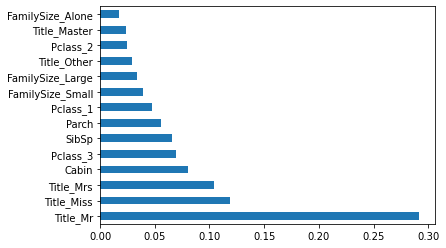

In [1108]:
# Random Forest

random_forest = RandomForestClassifier()
random_forest.fit(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
acc_random_forest

feat_importances = pd.Series(random_forest.feature_importances_, index=X_train.columns)
feat_importances.nlargest(100).plot(kind='barh')

<AxesSubplot:>

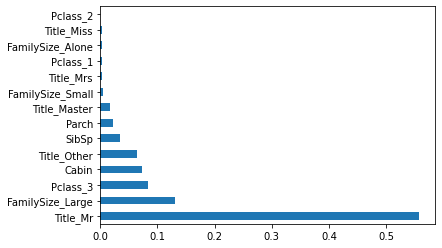

In [1109]:
# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, y_train)
acc_decision_tree = round(decision_tree.score(X_train, y_train) * 100, 2)
acc_decision_tree

feat_importances = pd.Series(decision_tree.feature_importances_, index=X_train.columns)
feat_importances.nlargest(100).plot(kind='barh')

In [1110]:
# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, y_train)
acc_sgd = round(sgd.score(X_train, y_train) * 100, 2)
acc_sgd

80.47

In [1111]:
# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, y_train)
acc_linear_svc = round(linear_svc.score(X_train, y_train) * 100, 2)
acc_linear_svc

C:\Users\DJaskulski\miniconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


82.49

In [1112]:
# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, y_train)
acc_perceptron = round(perceptron.score(X_train, y_train) * 100, 2)
acc_perceptron

80.36

In [1113]:
# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
acc_gaussian

80.36

# Cross-validation

In [1114]:
base = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
cross_val = KFold(n_splits=4)
scores = cross_val_score(base, X_train, y_train, cv=cross_val, scoring='accuracy')
base_score = round(scores.mean()*100, 2)
base_score

81.49

In [1115]:
knn = KNeighborsClassifier()
cross_val = KFold(n_splits=4)
scores = cross_val_score(knn, X_train, y_train, cv=cross_val, scoring='accuracy')
knn_score = round(scores.mean()*100, 2)
knn_score

79.8

In [1116]:
svc = SVC(random_state=1)
cross_val = KFold(n_splits=4)
scores = cross_val_score(svc, X_train, y_train, cv=cross_val, scoring='accuracy')
svc_score = round(scores.mean()*100, 2)
svc_score

82.72

In [1117]:
random_forest = RandomForestClassifier(random_state=1)
cross_val = KFold(n_splits=4)
scores = cross_val_score(random_forest, X_train, y_train, cv=cross_val, scoring='accuracy')
rf_score = round(scores.mean()*100, 2)
rf_score

80.92

In [1118]:
decision_tree = DecisionTreeClassifier(random_state=1)
cross_val = KFold(n_splits=4)
scores = cross_val_score(decision_tree, X_train, y_train, cv=cross_val, scoring='accuracy')
dt_score = round(scores.mean()*100, 2)
dt_score

79.58

In [1119]:
sgd = SGDClassifier(random_state=1)
cross_val = KFold(n_splits=4)
scores = cross_val_score(sgd, X_train, y_train, cv=cross_val, scoring='accuracy')
sgd_score = round(scores.mean()*100, 2)
sgd_score

78.56

In [1120]:
linear_svc = LinearSVC(random_state=1)
cross_val = KFold(n_splits=4)
scores = cross_val_score(linear_svc, X_train, y_train, cv=cross_val, scoring='accuracy')
lsvc_score = round(scores.mean()*100, 2)
lsvc_score

C:\Users\DJaskulski\miniconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
C:\Users\DJaskulski\miniconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


82.61

In [1121]:
perceptron = Perceptron(random_state=1)
cross_val = KFold(n_splits=4)
scores = cross_val_score(perceptron, X_train, y_train, cv=cross_val, scoring='accuracy')
percept_score = round(scores.mean()*100, 2)
percept_score

78.79

In [1122]:
gaussian = GaussianNB()
cross_val = KFold(n_splits=4)
scores = cross_val_score(gaussian, X_train, y_train, cv=cross_val, scoring='accuracy')
gnb_score = round(scores.mean()*100, 2)
gnb_score

77.0

# Grid search - hyperparameter optimization

In [1123]:
# decision_tree.get_params()

In [1135]:
param_grid = {"criterion": ['gini', 'entropy'],
              "splitter": ['best', 'random'],
              "max_depth": [3, 4, 5, 6, 7, 8, None],
              "min_samples_split": [3, 4, 5, 6, 7],
              "min_samples_leaf": [4, 5, 6, 7, 8],
              "max_features": [7, 8, 9, 10, 11],
              "max_leaf_nodes": [10, 11, 12, 13, 14]}

clf = GridSearchCV(
    decision_tree, 
    param_grid, 
    cv= 4,
    #verbose=1,
    n_jobs= -1,
    scoring= 'accuracy')

clf.fit(X_train, y_train)
pred_dt = clf.predict(X_test)

best_dt = clf.best_estimator_
gs_dt = round(clf.best_score_*100, 2)
clf.best_params_

{'criterion': 'gini',
 'max_depth': 5,
 'max_features': 10,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 5,
 'min_samples_split': 3,
 'splitter': 'random'}

In [1125]:
# random_forest.get_params()

In [1137]:
param_grid = {"max_depth": [3, 4, 5, 6, None],
              "max_features": [6, 7, 8, 9, 10],
              "min_samples_split": [2, 3, 4, 5],
              "min_samples_leaf": [2, 3, 4, 5],
              "bootstrap": [True],
              "criterion": ["gini", "entropy"]}

clf = GridSearchCV(
    random_forest, 
    param_grid, 
    cv= 4,
    #verbose=1,
    n_jobs= -1,
    scoring= 'accuracy')

clf.fit(X_train, y_train)
pred_rf = clf.predict(X_test)

best_rf = clf.best_estimator_
gs_rf = round(clf.best_score_*100, 2)
clf.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 4,
 'max_features': 7,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [1127]:
# svc.get_params()

In [1140]:
param_grid = {"C": [5, 6, 7, 8],
              "kernel": ['linear', 'rbf'],
              "gamma": ['scale', 'auto'],
              "decision_function_shape": ['ovo', 'ovr'],
              "tol": [1e-11, 1e-10, 1e-9, 1e-8]}

clf = GridSearchCV(
    svc, 
    param_grid, 
    cv= 4,
    #verbose=1,
    n_jobs= -1,
    scoring= 'accuracy')

clf.fit(X_train, y_train)
pred_svc = clf.predict(X_test)

best_svc = clf.best_estimator_
gs_svc = round(clf.best_score_*100, 2)
clf.best_params_

{'C': 6,
 'decision_function_shape': 'ovo',
 'gamma': 'auto',
 'kernel': 'rbf',
 'tol': 1e-11}

In [1129]:
# linear_svc.get_params()

In [1148]:
param_grid = {"C": [1, 2, 3, 4, 5],
              "dual": [True, False],
              "loss": ['hinge', 'squared_hindge'],
              "max_iter": [7, 8, 9, 10, 11],
              "multi_class": ['ovo', 'ovr'],
              "penalty": ['l1', 'l2'],
              "tol": [ 1e-40, 1e-25, 1e-20, 1e-15]}

clf = GridSearchCV(
    linear_svc, 
    param_grid, 
    cv= 4,
    #verbose=1,
    n_jobs= -1,
    scoring= 'accuracy')

clf.fit(X_train, y_train)
pred_lsvc = clf.predict(X_test)


best_lsvc = clf.best_estimator_
gs_lsvc = round(clf.best_score_*100, 2)
clf.best_params_

C:\Users\DJaskulski\miniconda3\lib\site-packages\sklearn\svm\_base.py:976: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "


{'C': 1,
 'dual': True,
 'loss': 'hinge',
 'max_iter': 9,
 'multi_class': 'ovr',
 'penalty': 'l2',
 'tol': 1e-40}

In [1131]:
# knn.get_params()

In [1154]:
param_grid = {"n_neighbors": [15, 16, 17, 18],
              "leaf_size": [2, 3, 5, 8],
              "algorithm": ['ball_tree', 'kd_tree', 'brute'],
              "metric": ['euclidean', 'manhattan', 'minkowski'],
              "weights": ['uniform', 'distance']}

clf = GridSearchCV(
    knn, 
    param_grid, 
    cv= 4,
    #verbose=1,
    n_jobs= -1,
    scoring= 'accuracy')

clf.fit(X_train, y_train)
pred_knn = clf.predict(X_test)


best_knn = clf.best_estimator_
gs_knn = round(clf.best_score_*100, 2)
clf.best_params_

{'algorithm': 'brute',
 'leaf_size': 2,
 'metric': 'manhattan',
 'n_neighbors': 15,
 'weights': 'uniform'}

# Validation

In [1155]:
models = pd.DataFrame({
    'BASIC ACC': [acc_base, acc_knn, acc_svc, acc_random_forest, acc_decision_tree,
                    acc_sgd, acc_linear_svc, acc_perceptron, acc_gaussian],
    
    'CV ACC': [base_score, knn_score, svc_score, rf_score, dt_score,
                    sgd_score, lsvc_score, percept_score, gnb_score],
    
    'GS ACC': [np.nan, gs_knn, gs_svc, gs_rf, gs_dt,
               np.nan, gs_lsvc, np.nan, np.nan]
},

    index = ["base model", "K-nearest Neighbors", "Support Vector Machines", "Random Forest", "Decision Tree",
             "Stochastic Gradient Descent", "Linear SVC", "Perceptron", "Gaussian Naive Bayes"])

models = models.sort_values(by='GS ACC', ascending=False)
models.index.name = 'Model'
models

,BASIC ACC,CV ACC,GS ACC
Model,,,
Random Forest,84.51,80.92,83.73
Decision Tree,84.51,79.58,83.28
Support Vector Machines,83.73,82.72,83.17
Linear SVC,82.49,82.61,82.49
K-nearest Neighbors,83.73,79.80,81.60
base model,83.84,81.49,NaN
Stochastic Gradient Descent,80.47,78.56,NaN
Perceptron,80.36,78.79,NaN
Gaussian Naive Bayes,80.36,77.00,NaN


# Submission

In [1160]:
output = pd.DataFrame({'PassengerId': test_data.PassengerId, 'Survived': pred_dt})
output.to_csv('my_submission_dt.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


# References


This notebook has been created based on great work done solving the Titanic competition and other sources.

    * https://www.kaggle.com/startupsci/titanic-data-science-solutions
    * https://www.kaggle.com/yassineghouzam/titanic-top-4-with-ensemble-modeling